# Characterization of Alzheimer's Disease through clustering of Medical notes

## Introduction

### Importing packages

In [971]:
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from gap_statistic import OptimalK

## Data Pre-processing

### Exploring the data

In [1010]:
path = "data/EO_AD-CONSULT.csv"
df = pd.read_csv(path)
df

,person_id,birth_datetime,gender_source_value,race_source_value,ethnicity_source_value,note_title,note_text
0,271,1932-02-09 00:00:00,FEMALE,WHITE,NOT HISPANIC,order_narative: CONSULT,"""[**NAME**], MD [**DATE**] 9:36 AM Geriat..."
1,1798,1928-06-16 00:00:00,FEMALE,WHITE,NOT HISPANIC,order_narative: CONSULT,"[**NAME**], MD [**DATE**] 2:57 PM Departm..."
2,1798,1928-06-16 00:00:00,FEMALE,WHITE,NOT HISPANIC,order_narative: CONSULT,"[**NAME**], MD [**DATE**] 7:32 PM Departm..."
3,1798,1928-06-16 00:00:00,FEMALE,WHITE,NOT HISPANIC,order_narative: CONSULT,"""[**NAME**], MD [**DATE**] 10:44 PM Geriat..."
4,1798,1928-06-16 00:00:00,FEMALE,WHITE,NOT HISPANIC,order_narative: CONSULT,"""[**NAME**], MD [**DATE**] 5:13 PM ..."
...,...,...,...,...,...,...,...
4242,258985,1946-12-18 00:00:00,FEMALE,WHITE,NOT HISPANIC,order_narative: CONSULT,"[**NAME**], MD [**DATE**] 7:36 AM Departm..."
4243,258985,1946-12-18 00:00:00,FEMALE,WHITE,NOT HISPANIC,order_narative: CONSULT,"[**NAME**], RN [**DATE**] 12:12 PM Referra..."
4244,258985,1946-12-18 00:00:00,FEMALE,WHITE,NOT HISPANIC,order_narative: CONSULT,"""[**NAME**], PA-C [**DATE**] 7:11 PM Depa..."
4245,258985,1946-12-18 00:00:00,FEMALE,WHITE,NOT HISPANIC,order_narative: CONSULT,"[**NAME**], MD [**DATE**] 10:26 PM Pt seen..."


### Calculating the age of each patient from their birth date

In [1011]:
# Converting the "birth_datetime" column to a datetime format 
df["birth_datetime"] = pd.to_datetime(df["birth_datetime"], format='%Y-%m-%d')
# Calculating the age by substracting the current date with the date in the dataframe
df["age"] = (pd.Timestamp('now') - df["birth_datetime"]).astype('timedelta64[Y]')
# Converting age to integer
df["age"]  = pd.to_numeric(df["age"], downcast='integer')
# Dropping the birth_datetime (it's useless at this point) 
df = df.drop("birth_datetime", axis=1)
# Re-arranging the order of the columns
df = df[['person_id', 'age', 'gender_source_value', 'race_source_value', 'ethnicity_source_value', 'note_title', 'note_text']]
df

,person_id,age,gender_source_value,race_source_value,ethnicity_source_value,note_title,note_text
0,271,90,FEMALE,WHITE,NOT HISPANIC,order_narative: CONSULT,"""[**NAME**], MD [**DATE**] 9:36 AM Geriat..."
1,1798,94,FEMALE,WHITE,NOT HISPANIC,order_narative: CONSULT,"[**NAME**], MD [**DATE**] 2:57 PM Departm..."
2,1798,94,FEMALE,WHITE,NOT HISPANIC,order_narative: CONSULT,"[**NAME**], MD [**DATE**] 7:32 PM Departm..."
3,1798,94,FEMALE,WHITE,NOT HISPANIC,order_narative: CONSULT,"""[**NAME**], MD [**DATE**] 10:44 PM Geriat..."
4,1798,94,FEMALE,WHITE,NOT HISPANIC,order_narative: CONSULT,"""[**NAME**], MD [**DATE**] 5:13 PM ..."
...,...,...,...,...,...,...,...
4242,258985,75,FEMALE,WHITE,NOT HISPANIC,order_narative: CONSULT,"[**NAME**], MD [**DATE**] 7:36 AM Departm..."
4243,258985,75,FEMALE,WHITE,NOT HISPANIC,order_narative: CONSULT,"[**NAME**], RN [**DATE**] 12:12 PM Referra..."
4244,258985,75,FEMALE,WHITE,NOT HISPANIC,order_narative: CONSULT,"""[**NAME**], PA-C [**DATE**] 7:11 PM Depa..."
4245,258985,75,FEMALE,WHITE,NOT HISPANIC,order_narative: CONSULT,"[**NAME**], MD [**DATE**] 10:26 PM Pt seen..."


#### Some statistics on the age of the patients

In [1012]:
df['age'].describe()

count    4247.000000
mean       78.561808
std        11.600322
min        26.000000
25%        65.000000
50%        86.000000
75%        88.000000
max        99.000000
Name: age, dtype: float64

### Creating the corpus from medical notes 

#### Using the note_text column for raw data

In [1013]:
corpus_raw = list(df["note_text"])

#### Removing words that don't contain much meaning from our notes

In [1045]:
words_to_remove = ["Department of Neurosurgery Date of Consult", "Department of Orthopedics Consultation Note Date of Consult", "Geriatric Medicine Consult Date of Consult", "INPATIENT MEDICAL NUTRITION THERAPY", "MSW", "RN" ,"evidence", "Read By", "images", "report", "concur", "findings", "agree", "seen", "residents", "resident", "Resident", "unspecified provider", "Released Date Time", "personally reviewed" ,"D.O", "MD", "M.D.", "Electronically Verified By", "NAME:", "[**NAME**]", "EXAM DATE:", "[**DATE**]", "LOC:", "[**LOCATION_INSTITUTE**]", "[**LOCATION_STREET**]", "[**LOCATION_ZIP**]", "[**LOCATION_CITY**]", "[**CONTACT_PHONE**]", "[**LOCATION_OTHER**]", "MRN:", "[**ID**]", "DOB:", "** VERIFIED **", "ORDERING MD:", "ORDER:", "ORD. SERVICE:", "ORD. LOC:", "TECH", "RMS# / INV#:"]
# words_to_remove = ["NAME:", "[**NAME**]", "EXAM DATE:", "[**DATE**]", "LOC:", "[**LOCATION_INSTITUTE**]", "[**LOCATION_STREET**]", "[**LOCATION_ZIP**]", "[**LOCATION_CITY**]", "[**CONTACT_PHONE**]", "[**LOCATION_OTHER**]", "MRN:", "[**ID**]", "DOB:", "** VERIFIED **", "ORDERING MD:", "ORDER:", "ORD. SERVICE:", "ORD. LOC:", "TECH", "RMS# / INV#:"]

# words_to_remove = words_to_remove + list(STOPWORDS)
corpus_clean = []
for item in corpus_raw:
    for word in words_to_remove:
        item = item.replace(word, '') 
    corpus_clean.append(item)

In [1046]:
df['note_text'].iloc[989]

", msw      11:22 am consult received.  patient's preference is for lakeside or st "

#### Taking each word from the cleaned corpus and making it lowercase

In [1047]:
corpus = [word.lower() for word in corpus_clean]
corpus[989]

",       11:22 am consult received.  patient's preference is for lakeside or st "

#### Adding the pre-processed version of the notes to the DataFrame

In [1048]:
df["note_text"] = corpus
df

,person_id,age,gender_source_value,race_source_value,ethnicity_source_value,note_title,note_text
0,271,90,FEMALE,WHITE,NOT HISPANIC,order_narative: CONSULT,""", 9:36 am : current patient location:..."
1,1798,94,FEMALE,WHITE,NOT HISPANIC,order_narative: CONSULT,", 2:57 pm department of radiology divis..."
2,1798,94,FEMALE,WHITE,NOT HISPANIC,order_narative: CONSULT,", 7:32 pm department of surgery date o..."
3,1798,94,FEMALE,WHITE,NOT HISPANIC,order_narative: CONSULT,""", 10:44 pm : subjective: reason for co..."
4,1798,94,FEMALE,WHITE,NOT HISPANIC,order_narative: CONSULT,""", 5:13 pm rheumatology in..."
...,...,...,...,...,...,...,...
4242,258985,75,FEMALE,WHITE,NOT HISPANIC,order_narative: CONSULT,", 7:36 am : requesting physician: s..."
4243,258985,75,FEMALE,WHITE,NOT HISPANIC,order_narative: CONSULT,", 12:12 pm referral made to wellcare con..."
4244,258985,75,FEMALE,WHITE,NOT HISPANIC,order_narative: CONSULT,""", pa-c 7:11 pm : subjective: reason ..."
4245,258985,75,FEMALE,WHITE,NOT HISPANIC,order_narative: CONSULT,", 10:26 pm pt and examined. full h&p t..."


## Creating Text embeddings

In [1049]:
model = SentenceTransformer("../models/sentence_transformers/emilyalsentzer_Bio_ClinicalBERT")

No sentence-transformers model found with name ../models/sentence_transformers/emilyalsentzer_Bio_ClinicalBERT. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at ../models/sentence_transformers/emilyalsentzer_Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from

### Some model parameters

The Transformer itself has a max sequence length of 512 tokens and it does not lowercase the input. For the pooling operation we will produce a 768-dimensional sentence embedding. We do this using mean pooling 

In [1050]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [1051]:
embeddings = model.encode(corpus, show_progress_bar=True)

Batches:   0%|          | 0/133 [00:00<?, ?it/s]

In [1052]:
embeddings

array([[-0.03169347, -0.2502394 , -0.11555168, ...,  0.16520211,
        -0.05251101, -0.08017787],
       [ 0.09112789, -0.07533339, -0.19162402, ...,  0.15824856,
        -0.05899323,  0.02386631],
       [ 0.1169114 , -0.19116387, -0.24990304, ...,  0.23425984,
        -0.09059227, -0.0572435 ],
       ...,
       [-0.14661424, -0.16234238, -0.24899487, ...,  0.23136312,
        -0.1450877 , -0.09871434],
       [ 0.21865042, -0.47718194, -0.08654806, ...,  0.02287953,
         0.1609921 , -0.06107221],
       [ 0.05582517, -0.15567304, -0.34738845, ...,  0.30638748,
        -0.19485605, -0.11413956]], dtype=float32)

In [1053]:
embeddings.shape

(4247, 768)

From the last cell, we see that our embeddings are high-dimensional as they contain several featured (768). To handle this, we use dimensionallity reduction so that we can both visualize and cluster our embeddings.

## Finding the right k

Before performing k means clustering we need to find the exact number K that can optimize our number of cluster. To do so, we will use gap statistic

In [1054]:
TOKENIZERS_PARALLELISM = False
optimalK = OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalK(embeddings, n_refs=50, cluster_array=np.arange(1,10))
print(f"The correct number of clusters is:{num_clusters}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/opt/conda/envs/rapids/lib/python3.9/site-packages/gap_statistic/optimalK.py:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gap_df = gap_df.append(
/opt/conda/envs/rapids/lib/python3.9/site-packages/gap_statistic/optimalK.py:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gap_df = gap_df.append(
/opt/conda/envs/rapids/lib/python3.9/site-packages/gap_statistic/optimalK.py:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gap_df = gap_df.append(
/opt/conda/envs/rapids/lib/python3.9/site-packages/gap_statistic/optimalK.py:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gap_df = gap_df.append(
/opt/conda/envs/rapids/lib/python3.9

In [1055]:
optimalK.gap_df

,n_clusters,gap_value,ref_dispersion_std,sk,gap*,sk*,diff,diff*
0,1.0,1.019322,100.667773,0.000545,119324.606405,120511.988052,-0.433953,120740.650144
1,2.0,1.453879,111.079538,0.000604,142304.490438,143720.534177,-0.114745,143762.650173
2,3.0,1.569191,103.994305,0.000567,146537.698570,147995.858305,-0.030785,148004.822866
3,4.0,1.600670,126.915477,0.000694,147436.815786,148903.940081,-0.017357,148908.517163
4,5.0,1.618662,115.959013,0.000635,147897.731544,149369.432921,-0.029839,149379.071959
5,6.0,1.649102,109.558951,0.000600,148866.953094,150348.293509,-0.042921,150361.958600
6,7.0,1.692503,87.554373,0.000480,150241.763400,151736.768906,-0.084864,151763.341140
7,8.0,1.777898,96.876176,0.000532,152911.681740,154433.259480,0.050450,154416.095581
8,9.0,1.728007,101.712349,0.000559,151186.394478,152690.808319,NaN,NaN


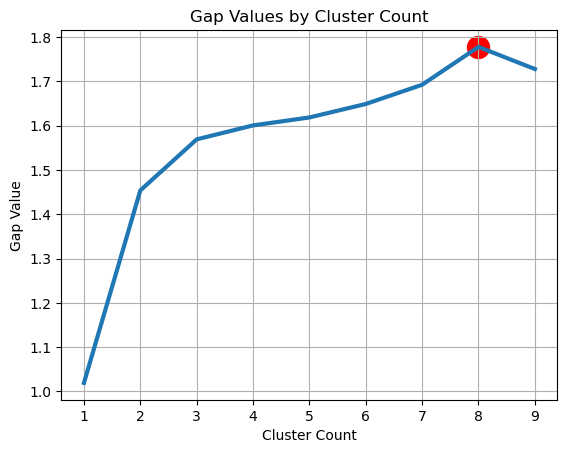

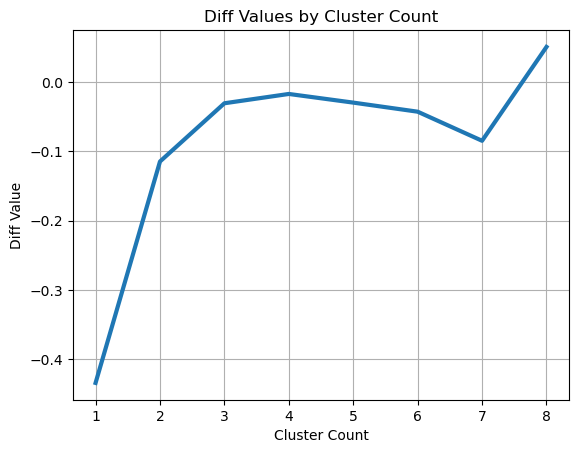

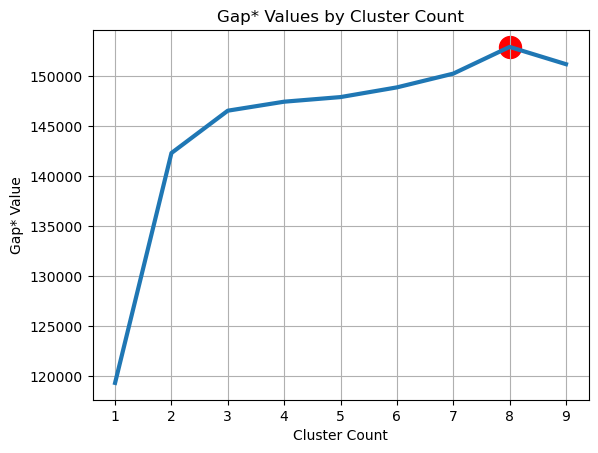

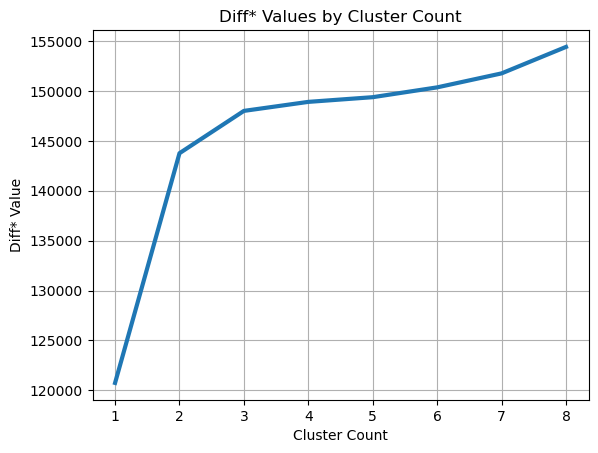

In [1056]:
optimalK.plot_results()

In [1057]:
# Create an empty dictionary to save the within cluster sum of square values
wcss = {} 
# Look through the number of clusters
for i in range(1,10):
  # Run kmeans model
  kmeans = KMeans(n_clusters=i, random_state=0).fit(embeddings)
  #Sum of squared distances of samples to their closest cluster center.
  wcss[i] = (kmeans.inertia_)
  # Print the within cluster sum of squares for each cluster number
  print(f'The within cluster sum of squares for {i} clusters is {wcss[i]}')

The within cluster sum of squares for 1 clusters is 67365.015625
The within cluster sum of squares for 2 clusters is 43368.46484375
The within cluster sum of squares for 3 clusters is 38508.86328125
The within cluster sum of squares for 4 clusters is 35762.671875
The within cluster sum of squares for 5 clusters is 34436.5703125
The within cluster sum of squares for 6 clusters is 33205.01171875
The within cluster sum of squares for 7 clusters is 31937.158203125
The within cluster sum of squares for 8 clusters is 31024.857421875
The within cluster sum of squares for 9 clusters is 30047.296875


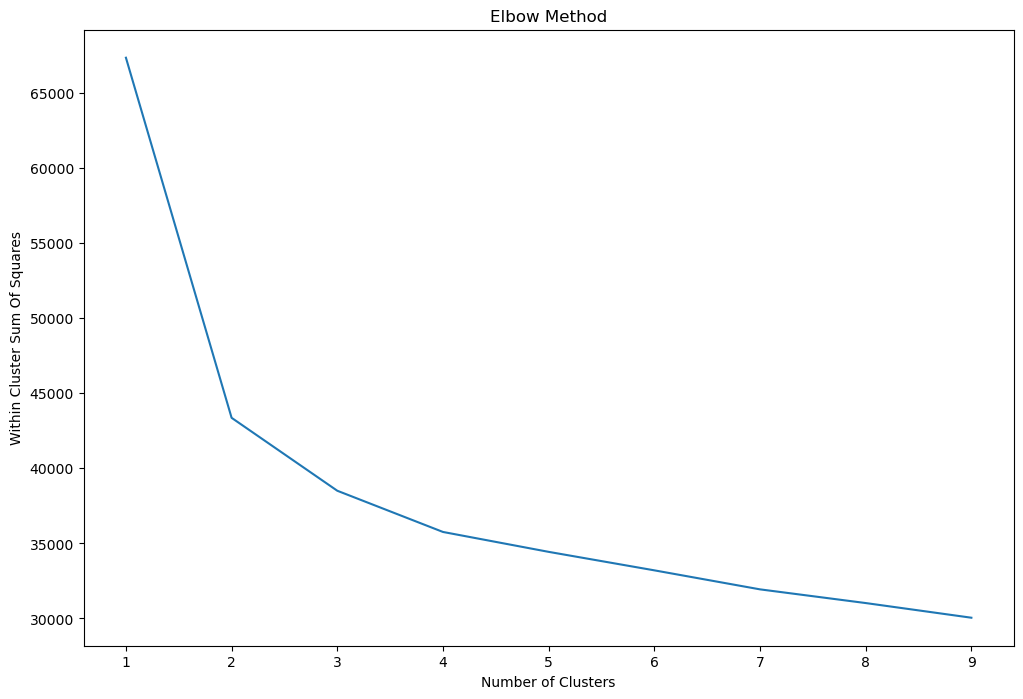

In [1058]:
# Visualization
plt.figure(figsize=(12,8))
plt.plot(list(wcss.keys()),list(wcss.values()))
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')    
plt.ylabel('Within Cluster Sum Of Squares')
plt.show()

## Dimensionality Reduction

In [1059]:
reducer = umap.UMAP(metric="cosine", n_neighbors=num_clusters, n_components=2)
umap_embedding = reducer.fit_transform(embeddings)
umap_embedding.shape

(4247, 2)

## Clustering with K-means

In [1060]:
cluster = KMeans(n_clusters=num_clusters)
cluster.fit(umap_embedding)
cluster_assignment = cluster.labels_

In [1061]:
print(f"Running K means with {num_clusters} clusters")

Running K means with 8 clusters


### Taking a look at the different categories

In [1062]:
cluster_assignment

array([2, 6, 2, ..., 2, 3, 2], dtype=int32)

### Putting the notes with their clusters for better visualization

In [1063]:
df_corpus = pd.DataFrame({"person_id": df["person_id"], "Corpus": corpus, "Cluster": cluster_assignment})
df_corpus

,person_id,Corpus,Cluster
0,271,""", 9:36 am : current patient location:...",2
1,1798,", 2:57 pm department of radiology divis...",6
2,1798,", 7:32 pm department of surgery date o...",2
3,1798,""", 10:44 pm : subjective: reason for co...",2
4,1798,""", 5:13 pm rheumatology in...",2
...,...,...,...
4242,258985,", 7:36 am : requesting physician: s...",2
4243,258985,", 12:12 pm referral made to wellcare con...",2
4244,258985,""", pa-c 7:11 pm : subjective: reason ...",2
4245,258985,", 10:26 pm pt and examined. full h&p t...",3


## Data Visualization

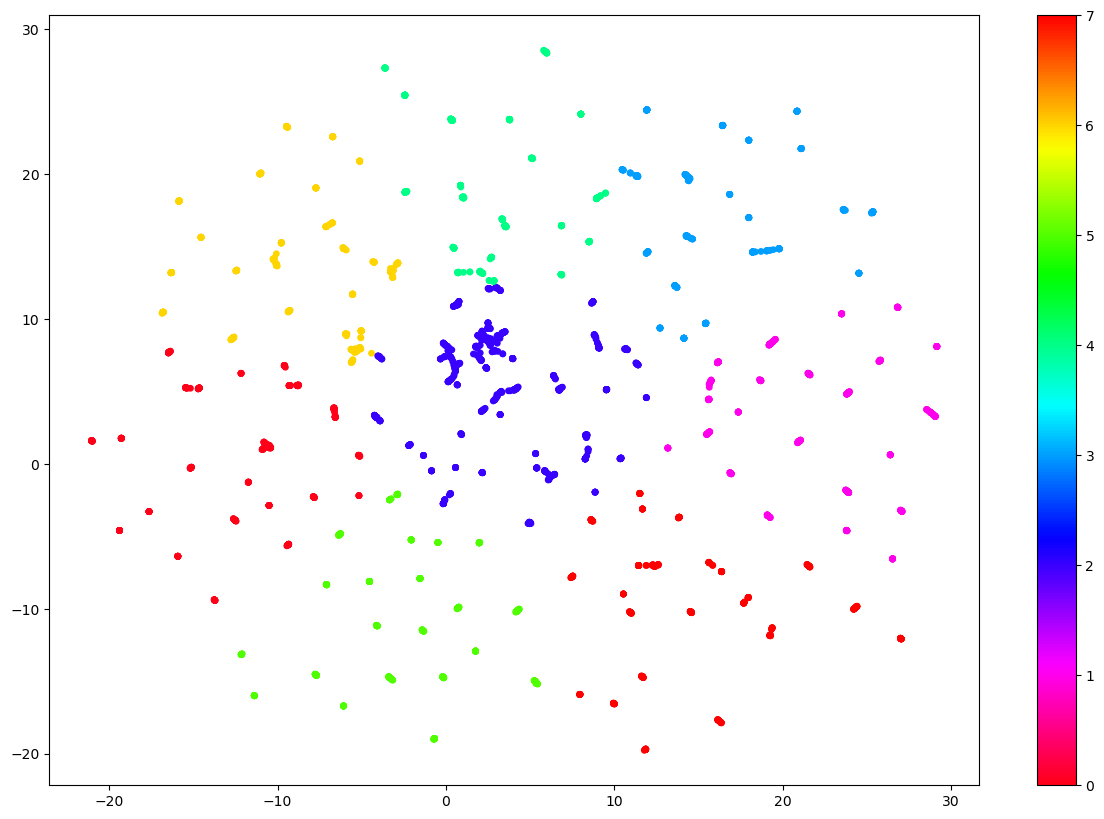

In [1064]:
# Prepare data
result = pd.DataFrame(umap_embedding, columns=['x', 'y'])
result['labels'] = cluster_assignment

# Visualize clusters
fig, ax = plt.subplots(figsize=(15, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=15)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=15, cmap='hsv_r')
plt.colorbar()

In [1067]:
docs_df = pd.DataFrame(corpus, columns=["Doc"])
docs_df['Topic'] = cluster_assignment
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [1068]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(corpus))

In [1069]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df)
topic_sizes

/opt/conda/envs/rapids/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic,Size
2,2,911
1,1,538
7,7,516
0,0,491
6,6,478
5,5,458
4,4,450
3,3,405


In [1125]:
docs_per_topic['Doc']

0    ,        8:56 pm patient is a 70 year old male...
1    ,       12:44 pm case management consult recei...
2    ",        9:36 am :  current patient location:...
3    ,       11:20 am wct consult completed, please...
4    "       2:08 pm cm consult received for the fo...
5    ,        9:57 am department of surgery divisio...
6    ,        2:57 pm department of radiology divis...
7           4:41 pm consult for a rolling walker ha...
Name: Doc, dtype: object

In [1121]:
top_n_words

{0: [('rd', 0.002266960752589694),
  ('en', 0.0022345452828264343),
  ('240', 0.002166671402265095),
  ('vein', 0.0021622934099837536),
  ('inr', 0.002042554383268002),
  ('malignant', 0.0019753002933502743),
  ('atrial', 0.001951348831746694),
  ('mmhg', 0.001913615841368115),
  ('colon', 0.0019075030543652235),
  ('neoplasm', 0.0018693037447783689),
  ('153', 0.0018509481926003864),
  ('chf', 0.0018491130230509363),
  ('doppler', 0.0018423627273958976),
  ('misc', 0.0017870473372219213),
  ('nos', 0.0017742591461796789),
  ('fibrillation', 0.0017666906547858983),
  ('unchanged', 0.001755518331020986),
  ('copd', 0.0017479970883274773),
  ('estimated', 0.0017393391589454162),
  ('nutrition', 0.0017353388083258068)],
 1: [('progress', 0.1059210500914185),
  ('complete', 0.08243207550903316),
  ('wound', 0.0340670870604918),
  ('note', 0.03216638370407503),
  ('sxs', 0.031950434623529124),
  ('radiates', 0.031758587133548156),
  ('relieving', 0.02901237461989659),
  ('exacerbated', 0.02

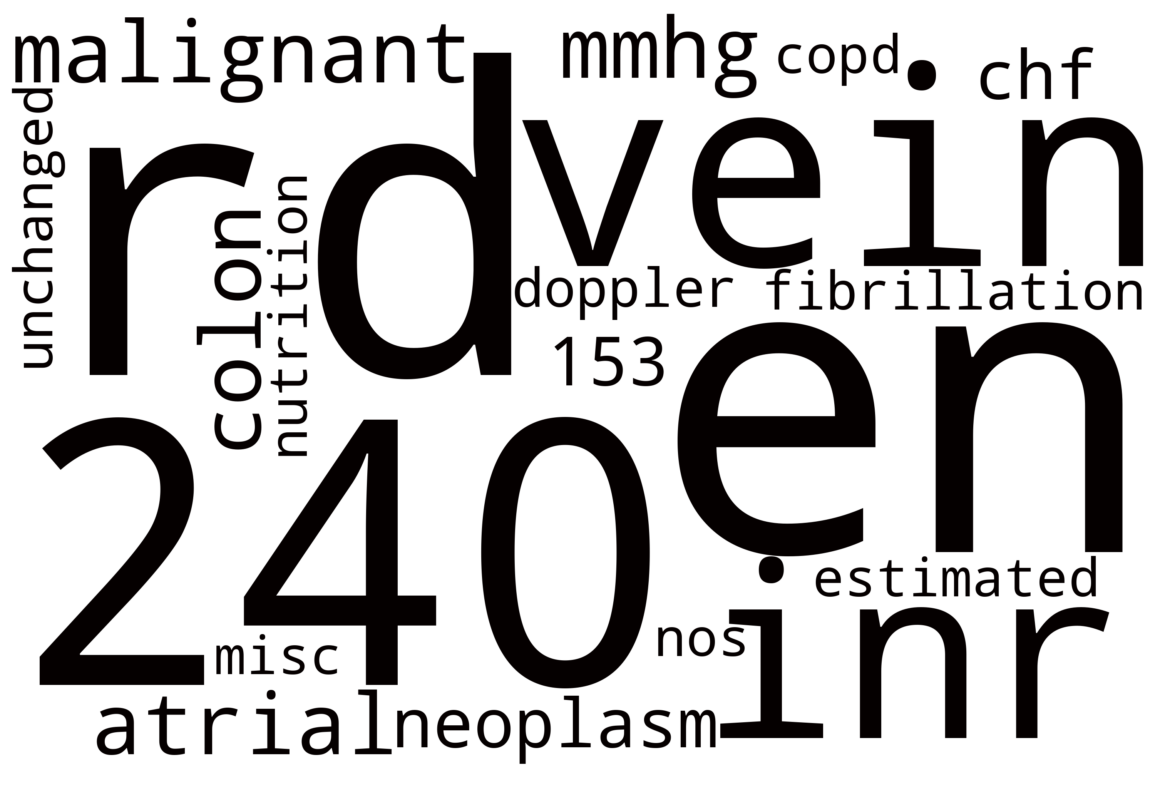

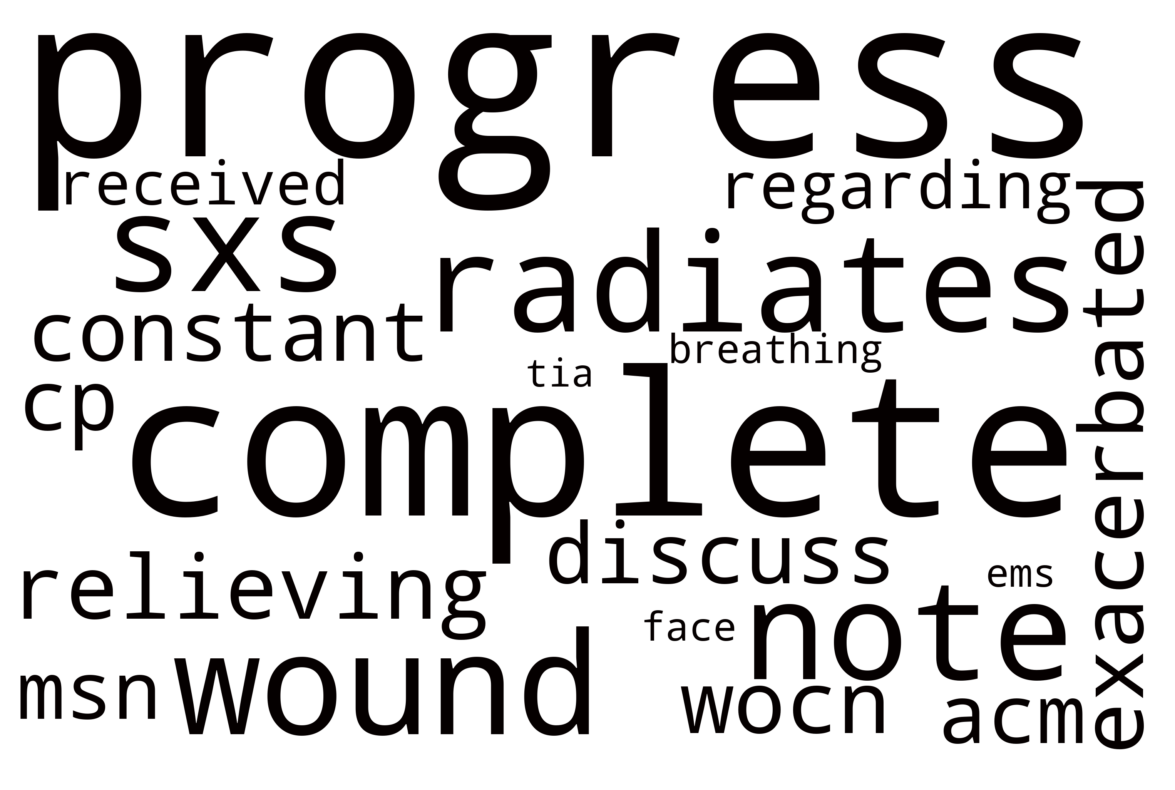

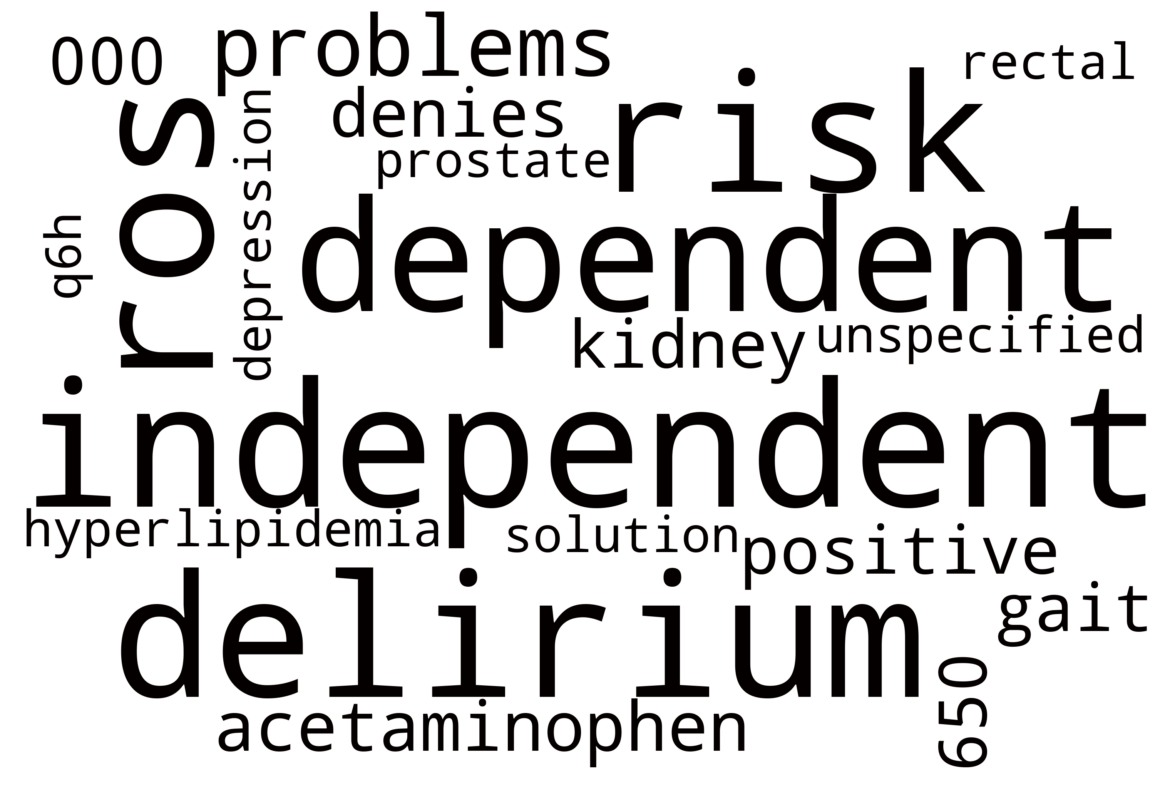

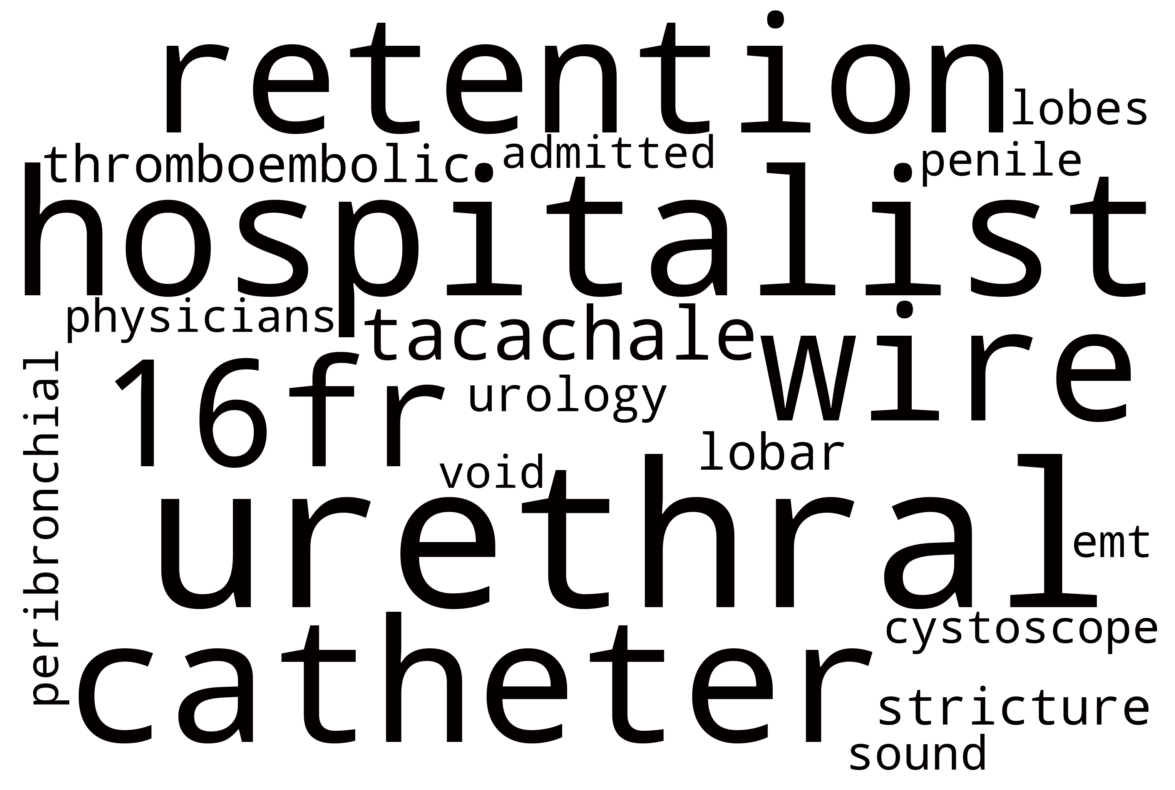

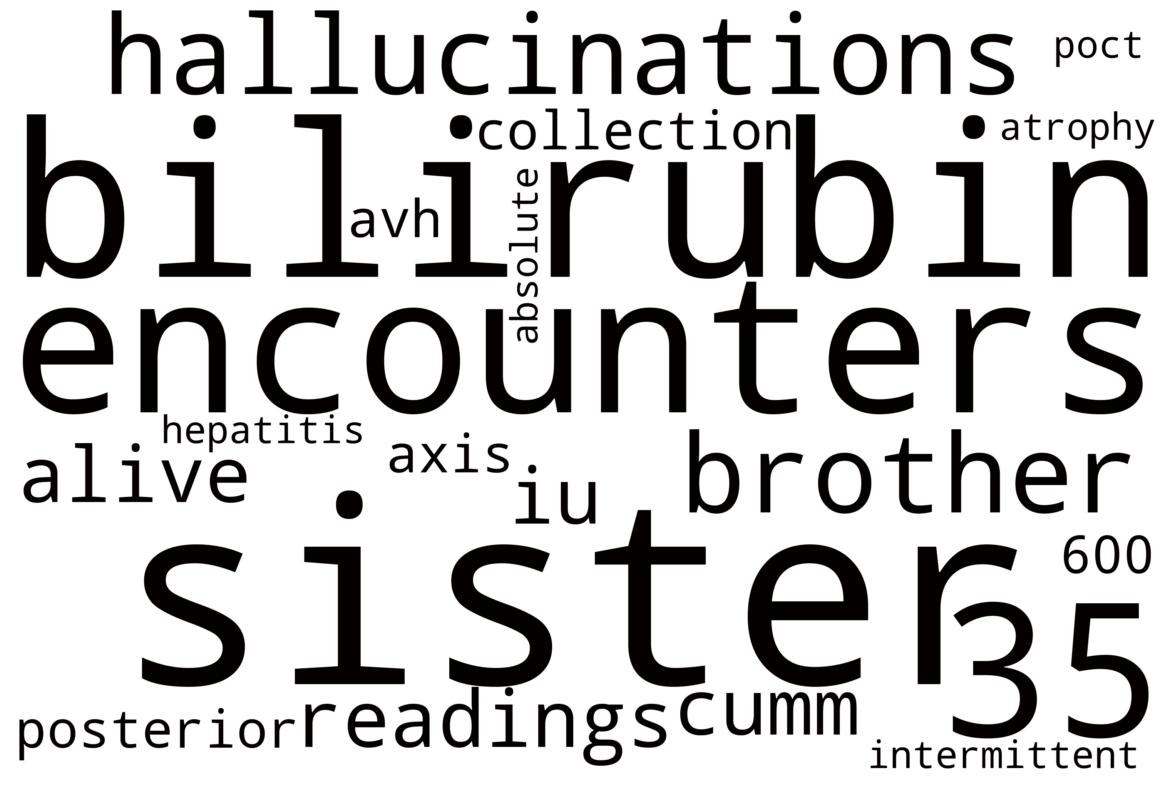

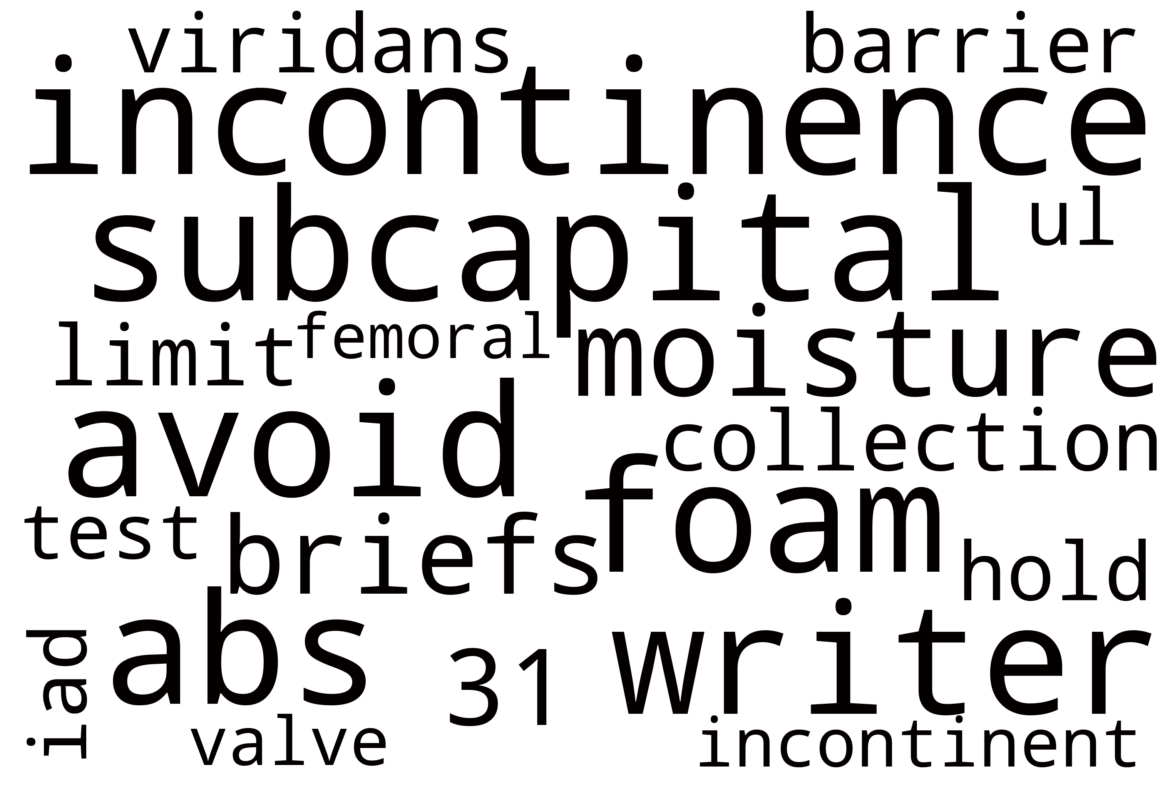

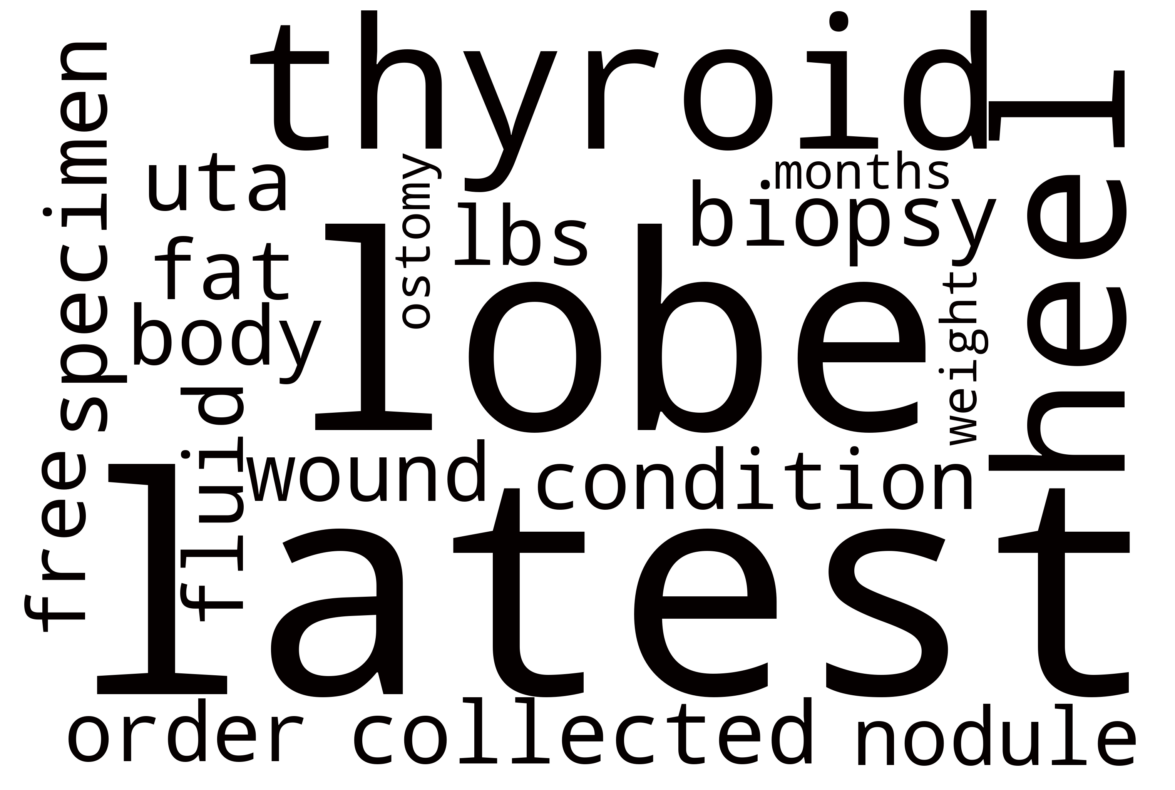

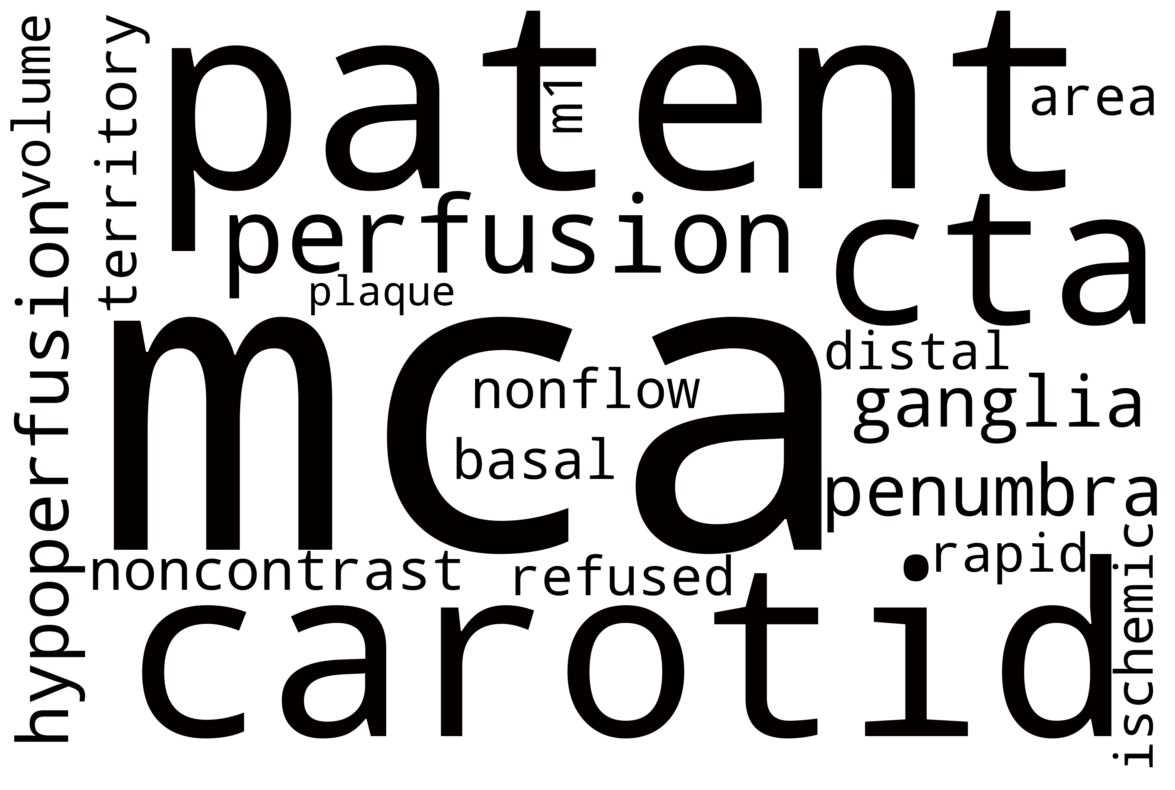

In [1124]:
def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")

for i in range(num_clusters):    
    wordcloud = WordCloud(stopwords=STOPWORDS, width=3000, height=2000, background_color="white", max_words=1000).generate_from_frequencies(dict(top_n_words[i]))
    # set the word color to black
    wordcloud.recolor(color_func = black_color_func)# set the figsize
    plt.figure(figsize=[15,10])
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')